# [Going Deeper NLP 06] 영화 장르 간 편향성 측정해 보기

영화 시놉시스 코퍼스를 이용해 영화 구분, 장르 간의 편향성을 측정하는 프로젝트 

---

## 프로젝트 목표
---
- WEAT score를 이해하고, 단어 임베딩 간의 편향성(관계)측정하는 메커니즘을 이해한다.
- 영화 시놉시스 데이터를 전처리한다.
- 해당 프로젝트에서 개선점을 찾는다. 

## 프로젝트 설명
---
1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. target, attribute 단어 셋 만들기
4. WEAT score 계산과 시각화

    
## 1. 영화 시놉시스 데이터에서 코퍼스 만들기

In [1]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

- 명사 단어만 사용하기 위해 konlpy패키지를 이용합니다.

In [2]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []    # corpus 저장
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [15]:
print(len(tokenized))

71156


In [4]:
tokenized

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤'],
 ['사랑', '두', '사람', '상우', '주체', '수', '정도', '그녀'],
 ['겨울', '만난', '두', '사람', '관계', '봄', '지나', '여름', '맞이', '삐걱', '거', '린다'],
 ['이혼', '경험', '은수', '상우', '결혼', '생각', '표정', '내비'],
 ['사랑', '상우', '은수', '단호', '말'],
 ['것', '사랑', '그', '사실', '상우', '어찌'],
 ['은수', '상우', '미련', '집착', '감정', '이기', '못', '서울', '강릉', '간다'],
 ['유사',
  '연령',
  '성별',
  '빈부',
  '차이',
  '정치',
  '입장',
  '불문',
  '국민',
  '통합',
  '온',
  '애국심',
  '성역',
  '일침',
  '다큐멘터리',
  '재작년',
  '전국',
  '민족',
  '민주',
  '유가족',
  '협의',
  '회의',
  '장기',
  '농성',
  '인상',
  '다큐멘터리',
  '민들레',
  '를',
  '독립영화',
  '집단',
  '눈사람',
  '이',
  '우리',
  '사회',
  '구석구석',
  '발',
  '애국심',
  '민족주의',
  '강요',
  '현장',
  '발굴',
  '카메라',
  '박홍',
  '서강대',
  '명예',
  '총장',
  '이도형',
  '한국',
  '논단',
  '발행',
  

## 2. 추출한 corpus로 embedding model 생성

In [5]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)
model.most_similar(positive=['영화'])

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


[('작품', 0.897576630115509),
 ('다큐멘터리', 0.8563284873962402),
 ('드라마', 0.8375741243362427),
 ('버자이너', 0.827782154083252),
 ('영화로', 0.8196532726287842),
 ('스토리', 0.8141896724700928),
 ('코미디', 0.8138607740402222),
 ('형식', 0.8132520914077759),
 ('보이스오버', 0.8067157864570618),
 ('소재', 0.805908739566803)]

In [10]:
model.most_similar(positive=['사랑'])

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('아르튬', 0.7909389734268188),
 ('정해준', 0.7134800553321838),
 ('첫사랑', 0.7080249786376953),
 ('진심', 0.7055633664131165),
 ('고백', 0.6970900297164917),
 ('이별', 0.6961969137191772),
 ('나비문신', 0.6952760219573975),
 ('행복', 0.6922249794006348),
 ('연애', 0.6914761066436768),
 ('만남', 0.6898940205574036)]

In [11]:
model.most_similar(positive=['연극'])

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('영화감독', 0.896980881690979),
 ('시나리오', 0.8932573795318604),
 ('배우', 0.8874497413635254),
 ('연기', 0.882240891456604),
 ('영감', 0.8821208477020264),
 ('시대극', 0.8804759979248047),
 ('대본', 0.8753785490989685),
 ('차이밍량', 0.8612754940986633),
 ('각색', 0.860957145690918),
 ('캐스팅', 0.8545063734054565)]

- 키워드로 넣는 단어들과 비슷한 단어를 잘 출력하는 것을 볼 수 있습니다.

## 3. target, attribute 단어 셋 만들기
- target X, Y 와 attribute A, B에 대한 단어 셋 생성
- 영화 장르와 영화 구분(예술, 일반)정보를 사용 

In [12]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [13]:
art = read_token(art_txt)  # 예술 영화
gen = read_token(gen_txt)  # 일반 영화

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [19]:
print(type(art), type(gen))
print(len(art), len(gen))

<class 'str'> <class 'str'>
620208 3014815


In [20]:
art[:100]

'사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 신신애 분 살 겨울 그 지방 방송국 라디오 은수 이영애 분 를 자연 소리 채집 라디오 프로'

In [21]:
gen[:100]

'유사 연령 성별 빈부 차이 정치 입장 불문 국민 통합 온 애국심 성역 일침 다큐멘터리 재작년 전국 민족 민주 유가족 협의 회의 장기 농성 인상 다큐멘터리 민들레 를 독립영화 집단 '

- TF-IDF방식을 이용해 단어 셋을 구성합니다.

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [23]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [24]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

- 두 개념 corpus에서 중복되는 단어를 제거합니다.

In [25]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): 
        target_art.append(w1_[i])
        
    if len(target_art) == n: 
        break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): 
        target_gen.append(w2_[i])
        
    if len(target_gen) == n: 
        break

In [28]:
len(w1_), len(w2_)

(100, 100)

In [30]:
target_art, target_gen

(['아빠',
  '음악',
  '결심',
  '운명',
  '지금',
  '여인',
  '이름',
  '이후',
  '준비',
  '감정',
  '만난',
  '처음',
  '충격',
  '누구',
  '그린'],
 ['서울',
  '애니메이션',
  '여성',
  '가지',
  '주인공',
  '대해',
  '연출',
  '사회',
  '다큐멘터리',
  '부문',
  '섹스',
  '바로',
  '의도',
  '계획',
  '정체'])

In [31]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [32]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [42]:
len(genre)

21

In [43]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [46]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

## WEAT score
- word embedding(벡터)간의 유사도를 측정함으로 단어를 분류하거나, 편향성을 확인할 수 있습니다.
- WEAT score는 두 벡터의 유사도를 측정하기 위해 cosine similarity를 이용합니다.
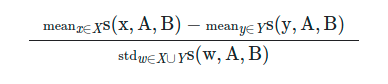   
WEAT score의 정의에 있는 $s(w, A, B)$를 먼저 이해해보겠습니다.   
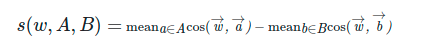
- attribute A or B와 어떤 유사도를 갖는지 확인하기 위한 식
- cosine similarity를 이용하기 위해 attribute A, B를 개념축 A-B로 두고, 확인하고자 하는 target w단어와의 방향의 유사성을 계산합니다.  
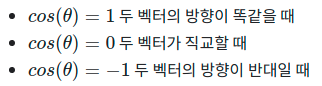     

- WEAT score의 분자는 편향성의 값을 나타냅니다.
- 편향성의 값은 -2에서 2 사이의 값을 갖습니다. 
- 이 값을 정규화해주는 것으로 최종 WEAT score를 계산할 수 있습니다.
---
## 4. WEAT score 계산하기

In [57]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

- 영화 시놉시스 데이터를 계산하기 전, 예시 데이터를 생성해 계산하겠습니다.
- **유쾌함**과 **불쾌함**을 나타낼 수 있는 단어들이 **꽃** 혹은 **곤충** 단어와 어떤 관계를 갖고 있는지, 어떤 편향성을 보이는지 계산하겠습니다.

In [68]:
target_X = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
target_Y = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

attribute_A = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
attribute_B = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}

In [69]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [70]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(X)
print(Y)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [71]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B  #, c_a, c_b

print(s(target_X['사랑'], A, B))

0.5901751654626237


- WEAT score가 양수, 1에 가까운 값이 나왔습니다.
- 타겟 단어인 **사랑**은, attribute A(꽃)과 더 가까운 단어라는 것을 알 수 있습니다. 

In [72]:
print(s(target_Y['재난'], A, B))

-0.6691842929755343


- WEAT score가 음수, -1에 가까운 값이 나왔습니다.
- 타겟 단어인 **재난**은, attribute B(곤충)과 더 가까운 단어라는 것을 알 수 있습니다.
---
- 각 target X, Y와 attribute A, B 사이의 평균값을 확인합니다.

In [73]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.37181942 0.41632807 0.21117431]
0.333


In [74]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.39609272 -0.37389852 -0.41242037]
-0.394


- WEAT score 계산 함수 생성

In [75]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B) # x의 편향
    s_Y = s(Y, A, B) # y의 편향 

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

# WEAT score 계산
print(round(weat_score(X, Y, A, B), 3))

1.97


- target X, Y의 attribute A, B에 대한 WEAT score를 계산했습니다. 
- **1.932**로 높게 나온 값은 유쾌한 단어(X)는 꽃(A)과 가까우며, 불쾌한 단어(Y)는 곤충(B)과 가깝다는 것을 알 수 있습니다.

## 5. 시각화

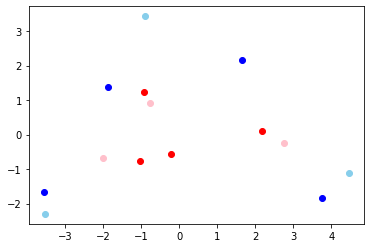

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

- X-A, Y-B가 가깝게 표현되었습니다. 

### 이제 영화 시놉시스 데이터에서 만들어 둔 벡터를 이용해 계산해보겠습니다.
- attribute A : '드라마'
- attribute B : '액션'
- target X : art, 예술영화
- target Y : gen, 일반영화
---
- attribute는 만들어둔 영화 장르에서 유연하게 선택 가능합니다.
- target인 예술영화 혹은 일반영화가 어떤 장르에 가까운지 확인할 수 있습니다.

In [77]:
# 구현결과를 담을 21x21 matrix
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [78]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [82]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i],genre_name[j],matrix[i][j])
            

SF 멜로로맨스 -1.3373097
공포(호러) 다큐멘터리 1.1664572
기타 멜로로맨스 -1.1885022
다큐멘터리 멜로로맨스 -1.4822986
다큐멘터리 미스터리 -1.3009976
다큐멘터리 성인물(에로) -1.2312536
다큐멘터리 스릴러 -1.1620758
멜로로맨스 뮤지컬 1.1070938
멜로로맨스 범죄 1.243426
멜로로맨스 서부극(웨스턴) 1.1448554
멜로로맨스 애니메이션 1.1601299
멜로로맨스 전쟁 1.4281268
미스터리 전쟁 1.1273814


### WEAT score 결과 해석
- 예술영화/일반영화 : SF/멜로로맨스 = -1.3373097   
    : 예술영화-멜로로맨스, 일반영화-SF 
- 예술영화/일반영화 : 공포(호러)/다큐멘터리 = 1.1664572   
    : 예술영화-공포(호러), 일반영화-다큐멘터리
- 다큐멘터리는 모두 일반영화와 관련이 높은 것으로 나왔으며, 멜로로맨스는 예술영화와 관련이 높은 것으로 나왔다. 
---
### 시각화

<AxesSubplot:>

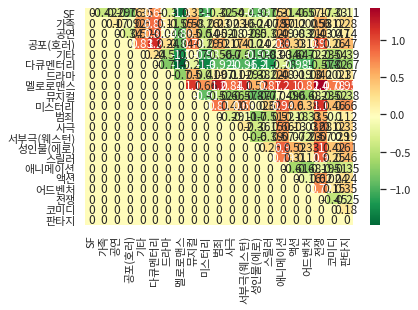

In [83]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

- 시각화한 heatmap을 보면, 멜로로맨스와 애니메이션이 가장 편향성이 크게 나타나는 것을 볼 수 있다.

# 루브릭 평가
---
1. **주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.**   

    - 학습한 워드임베딩 모델이 정상적으로 작동하는 것을 유사한 단어를 보여주는 most_similar함수로 확인했다. 


2. **영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.**

    - 중복을 제거하는 과정을 통해 단어 셋을 구축할 수 있었다.
    
     
3. **WEAT score 계산 및 시각화를 정상적으로 진행하였다.** 
 
     - WEAT score를 계산하고 시각화하여 결과를 분석했다. 

    
# 회고
---

## 어려웠던 부분 
- 수식을 이해하는 부분이 어려웠으나 퍼실 @홍진표님의 도움으로 잘 이해하고 넘어갈 수 있었다.

## 알아낸 점 혹은 모호한 부분 
- 데이터의 편향이 있을 수 있다라는 점을 알고 있었는데 이를 평가할 수 있는 지표가 있다는 점을 배울 수 있었다. 
- 이런 편향에 대해 어떠한 처리가 필요한 것인지 궁금하지만 이는 임베딩을 만드는 모델에서 처리해야할 것 같다. 
- 또한 편향이 데이터의 특성이 될 수 있는데, 편향을 없애는 것외에 편향이 있다는 사실을 모델에 적용할 수 있는 방법에 대해 고민이 된다.
- 행렬 계산을 통해 여러 attribute에 대한 WEAT score를 한 번에 계산할 수 있었다. 
- 예술영화와 일반영화에 대한 구분 기준이 모호하다고 생각한다. 두 구분은 영화 장르에 따라 구분되지 않으며, 이는 두 구분을 대표하는 단어를 보면 중복되는 단어가 많으며 기준이 모호하다는 것을 볼 수 있다. 
- 더 구분 기준이 뚜렷한 예시로 프로젝트를 진행했으면 결과에 대해 납득을 할 수 있었을 것이다. 

## 느낀 점 
- 지표를 공부하고 평가하는 방법을 배웠으니 이를 어디에 활용하면 더 좋은 모델을 구성할 수 있을지 고민하고 싶다. 